In [58]:
import gym
gym.__version__
# 0.26.2

'0.26.2'

In [59]:
# TEST gym environment
import gym
import numpy as np
import time

#env = gym.make('LunarLander')
#env = gym.make('CartPole-v1', render_mode="human")
#env = gym.make('FrozenLake-v1')
env = gym.make('FrozenLake-v1', render_mode="human")

observation = env.reset(seed=42)
action_size = env.action_space.n
print('Number of actions:', action_size)
done = False
n_episodes = 1
for _ in range(n_episodes):
    while not done:
        action = np.random.randint(0, action_size)
        observation, reward, done, info, _ = env.step(action)
        print('Action:', action)
        print('Observation:', observation)
        print('Reward:', reward)
        env.render()
        time.sleep(0.1)
    done = False
    env.reset()
env.close()

Number of actions: 4
Action: 0
Observation: 0
Reward: 0.0
Action: 0
Observation: 4
Reward: 0.0
Action: 1
Observation: 5
Reward: 0.0


In [65]:
# Imports
import random
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [61]:
# Replay Buffer Class
class ReplayBuffer:
    def __init__(self, buffer_size):
        # Initialize the replay buffer with a given maximum size.
        self.buffer_size = buffer_size
        # Create an empty buffer list to store experiences.
        self.buffer = []
        # Initialize the starting position of the buffer.
        self.position = 0

    def add(self, state, action, reward, next_state):
        # Add a new experience to the buffer.
        experience = (state, action, reward, next_state)
        # Add a None element to the buffer list if it's not full yet.
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(None)
        # Add the experience to the buffer at the current position.
        self.buffer[self.position] = experience
        # Increment the position and wrap around if it goes beyond the buffer size.
        self.position = (self.position + 1) % self.buffer_size

    def sample(self, batch_size):
        # Sample a random batch of experiences from the buffer.
        batch = random.sample(self.buffer, min(batch_size, len(self.buffer)))
        # Unzip the batch of experiences into separate lists of states, actions, rewards, and next states.
        states, actions, rewards, next_states = zip(*batch)
        # Convert to a PyTorch tensor with various data type.
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64).reshape(-1,1),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
        )

    def __len__(self):
        # Return the current size of the buffer.
        return len(self.buffer)


In [75]:
# Neural Network and Agent Classes

# Define a neural network class that inherits from the PyTorch nn.Module class.
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        # Define the neural network layers and activation functions.
        self.fc1 = nn.Linear(input_dims[0], 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, n_actions)
        self.softmax = nn.Softmax()

        # Define the optimizer and loss function for training the neural network.
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    # Define the forward pass of the neural network.
    def forward(self, state):
        layer1 = torch.relu(self.fc1(state))
        layer2 = torch.relu(self.fc2(layer1))
        actions = self.fc3(layer2)

        return actions

# Define an agent class for training the neural network.
class Agent():
    def __init__(self, input_dims, n_actions, lr=1e-4, gamma=0.1,
                 epsilon=1.0, eps_dec=15e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        # Create an instance of the neural network for the agent.
        self.Q_network = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    # Define a function for choosing an action given an observation.
    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            # Use the neural network to predict the Q-values for the current state.
            state = torch.tensor(observation, dtype=torch.float).to(self.Q_network.device)
            actions = self.Q_network.forward(state)
            # Choose the action with the highest Q-value.
            action = torch.argmax(actions).item()
        else:
            # Choose a random action with probability epsilon.
            action = np.random.choice(self.action_space)

        return action

    # Define a function for decrementing epsilon over time to decrease exploration.
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    # Define a function for training the neural network with a batch of experiences.
    def learn(self, states, actions, rewards, states_):
        self.Q_network.optimizer.zero_grad()
        # Convert the data to PyTorch tensors and move to the device for training.
        states = torch.tensor(states).to(self.Q_network.device)
        actions = torch.tensor(actions).to(self.Q_network.device)
        rewards = torch.tensor(rewards).to(self.Q_network.device)
        states_ = torch.tensor(states_).to(self.Q_network.device)

        # Use the neural network to predict the Q-values for the current and next states.
        q_pred = self.Q_network.forward(states).gather(1, actions)
        q_next, _ = torch.max(self.Q_network.forward(states_), dim=1)

        # Calculate the target Q-values based on the current rewards and expected future rewards.
        q_target = rewards + self.gamma*q_next

        # Calculate the mean squared error loss between the predicted and target Q-values.
        loss = self.Q_network.loss(q_target, q_pred.squeeze()).to(self.Q_network.device)
        # Perform backpropagation to update the neural network weights.
        loss.backward()
        self.Q_network.optimizer.step()
        # Decrease the epsilon value to decrease exploration over time.
        self.decrement_epsilon()



In [81]:
# Convert integer to array
def int_to_array(intn):
    # Create a numpy array of zeros with 16 elements.
    bin_arr = np.zeros(16)
    # Set the element of the numpy array at index intn to 1.
    bin_arr[intn] = 1
    return bin_arr

# Print the binary array representation of the integer 15.
print(int_to_array(15))

# Define a function for managing rewards based on the current and next observations.
def reward_managment(obs, obs_):
    # If the next observation is in a specific set of states, return a negative reward.
    if obs_ in [5, 7, 11, 12]:
        return -1
    # If the next observation is the same as the current observation, return a negative reward.
    elif (int_to_array(obs_) == obs).all():
        return -1
    # If the next observation is the goal state, return a positive reward.
    elif obs_ == 15:
        return 10
    # Otherwise, return a small negative reward.
    else:
        return -0.1

# plot score and epsilon curves
def plot_score_epsilon(x_axis, scores, epsilons):
    fig, ax1 = plt.subplots()

    # Plot the first curve using the first y-axis.
    ax1.plot(x_axis, scores, 'b-', label='score')
    ax1.set_xlabel('x')
    ax1.set_ylabel('score', color='b')

    # Create a second y-axis object and plot the second curve using it.
    ax2 = ax1.twinx()
    ax2.plot(x_axis, epsilons, 'r-', label='epsilon')
    ax2.set_ylabel('epsilon', color='r')

    # Add a legend to the plot.
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower left')

    # Show the plot.
    plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


episode 10, last score -2.3, avg score nan epsilon 1.00
episode 20, last score -1.1, avg score -2.3 epsilon 1.00


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10956\2243067176.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states).to(self.Q_network.device)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10956\2243067176.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = torch.tensor(actions).to(self.Q_network.device)
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_10956\2243067176.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards).to(self.Q_network.device)
C:\Users\Utiliz

episode 30, last score -1.4, avg score -1.7 epsilon 0.99
episode 40, last score -11.9, avg score -1.6 epsilon 0.98
episode 50, last score -1.1, avg score -4.2 epsilon 0.97
episode 60, last score -1.1, avg score -3.6 epsilon 0.96
episode 70, last score -2.3, avg score -3.2 epsilon 0.95
episode 80, last score -6.1, avg score -3.0 epsilon 0.93
episode 90, last score -3.7, avg score -3.4 epsilon 0.92
episode 100, last score -7.2, avg score -3.4 epsilon 0.91
episode 110, last score -1.1, avg score -3.8 epsilon 0.91
episode 120, last score -1.1, avg score -3.7 epsilon 0.90
episode 130, last score -3.2, avg score -3.7 epsilon 0.89
episode 140, last score -2.1, avg score -3.9 epsilon 0.88
episode 150, last score -1.1, avg score -2.9 epsilon 0.87
episode 160, last score -2.3, avg score -2.9 epsilon 0.86
episode 170, last score -1.1, avg score -3.0 epsilon 0.85
episode 180, last score -1.1, avg score -2.9 epsilon 0.84
episode 190, last score -2.2, avg score -2.4 epsilon 0.83
episode 200, last sc

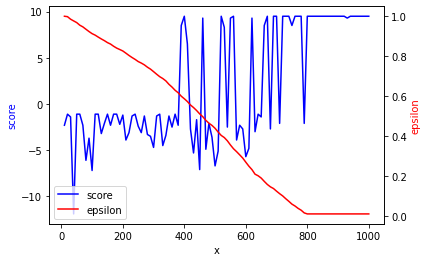

In [82]:
# Create the FrozenLake-v1 environment with slippery mode disabled.
env = gym.make('FrozenLake-v1', is_slippery=False)

# Define the number of episodes to run and initialize tracking variables.
n_episodes = 1000
x_axis, scores, epsilons = [], [], []

# Create an instance of the agent class.
agent = Agent(input_dims=(16,), n_actions=env.action_space.n)

# Initialize the replay buffer.
buffer_size = 64
batch_size = 16
replay_buffer = ReplayBuffer(buffer_size)

# Run the main training loop for the specified number of episodes.
for i in range(n_episodes):
    # Reset the environment and initialize the score, done flag, and observation.
    score = 0
    done = False
    state = int_to_array(env.reset(seed=42)[0])
    steps = 0

    # Run the episode until the environment returns done.
    while not done:
        # Choose an action based on the current observation and agent policy.
        action = agent.choose_action(state)

        # Take a step in the environment and update the score, done flag, and observation.
        state_, reward, done, info, _ = env.step(action)
        reward = reward_managment(state, state_)
        replay_buffer.add(state, action, reward, int_to_array(state_))
        if i>batch_size:
            states, actions, rewards, states_ = replay_buffer.sample(batch_size)
            agent.learn(states, actions, rewards, states_)
        state = int_to_array(state_)
        score += reward
        steps += 1

        # If the episode runs for more than 20 steps, force it to end.
        if steps>20:
            break

    # Print the episode statistics and track the score and epsilon value over time.
    if (i+1) % 10 == 0:
        avg_score = np.mean(scores[-10:])
        print(f'episode {i+1}, last score {score:.1f}, avg score {avg_score:.1f} epsilon {agent.epsilon:.2f}')
        x_axis.append(i+1)
        scores.append(score)
        epsilons.append(agent.epsilon)

# Plot the scores and epsilon values over time.
plot_score_epsilon(x_axis, scores, epsilons)


In [85]:
# Import required libraries.
import gym
import numpy as np
import time

# Set the exploration rate to zero to force the agent to choose actions based on its learned policy.
agent.epsilon = 0.0

# Create an instance of the FrozenLake-v1 environment with slippery mode disabled and rendering enabled.
env = gym.make('FrozenLake-v1', render_mode="human", is_slippery=False)

# Define a dictionary to map actions to human-readable names.
action_dict = {0: 'left', 1:'down', 2:'right', 3:'left'}

# Convert the initial observation returned by the environment to a numpy array.
observation = int_to_array(env.reset(seed=42)[0])

# Get the number of actions in the environment.
action_size = env.action_space.n
print('Number of actions:', action_size)

# Run a single episode of the environment using the agent's learned policy.
done = False
n_episodes = 1
for _ in range(n_episodes):
    while not done:
        # Print the current observation and chosen action.
        print('---')
        print('Observation:', observation)
        action = agent.choose_action(observation)
        print('Action:', action_dict[action])
        
        # Take a step in the environment and render the current state.
        observation, reward, done, info, _ = env.step(action)
        observation = int_to_array(observation)
        env.render()
        #time.sleep(0.1)

    # Reset the environment and the done flag for the next episode.
    done = False
    env.reset(seed=42)

# Close the environment viewer.
env.close()


Number of actions: 4
---
Observation: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Action: right
---
Observation: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Action: right
---
Observation: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Action: down
---
Observation: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Action: down
---
Observation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Action: down
---
Observation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Action: right
